## Семинар 2 "Распознавание рукописных цифр"

ФИО: Вербин Олег

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

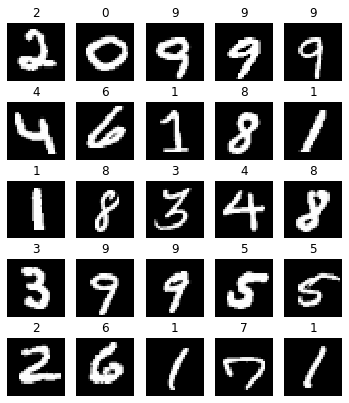

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [5]:
nl=NLLLoss()
losses_train=[]
losses_test=[]

net=NeuralNetwork([Linear(784, 100),Sigmoid(),Linear(100, 100),Sigmoid(),Linear(100, 10)])


test_iter=iter(test_loader)
for X,y in train_loader:
    X=X.view(X.shape[0],-1)
    X=X.numpy()
    y=y.numpy()
    
    try:
        x_test,y_test=next(test_iter)
    except StopIteration:
        test_iter=iter(test_loader)
        x_test,y_test=next(test_iter)
    finally:
        x_test=x_test.view(x_test.shape[0],-1)
        x_test=x_test.numpy()
        y_test=y_test.numpy()

    y_pred=net.forward(X)
    loss=nl.forward(y_pred,y)
    losses_train.append(loss)
    losses_test.append(nl.forward(net.forward(x_test),y_test))
    net.backward(nl.backward())
    net.step(0.1)




In [33]:
X_train=np.empty((60000,784))
y_train=np.empty((60000),dtype=int)

i=0
for X,y in train_loader:
    X=X.view(X.shape[0],-1)
    X=X.numpy()
    y=y.numpy()
    X_train[i:i+X.shape[0]]=X
    y_train[i:i+X.shape[0]]=y
    i+=X.shape[0]

In [34]:
X_test=np.empty((10000,784))
y_test=np.empty((10000),dtype=int)

i=0
for X,y in test_loader:
    X=X.view(X.shape[0],-1)
    X=X.numpy()
    y=y.numpy()
    X_test[i:i+X.shape[0]]=X
    y_test[i:i+X.shape[0]]=y
    i+=X.shape[0]
    
print(f'loss = {nl.forward(net.forward(X_test),y_test)}')

loss = 0.09024847174401497


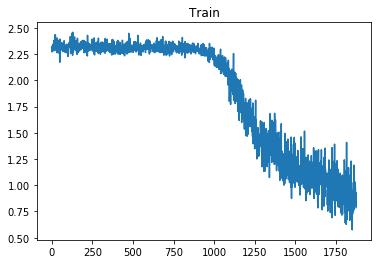

In [8]:
plt.plot(losses_train)
plt.title('Train')
plt.show()

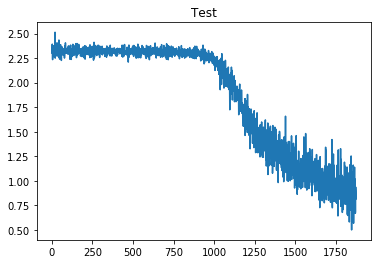

In [9]:
plt.plot(losses_test)
plt.title('Test')
plt.show()

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [10]:
class Relu:
    def __init__(self):
        pass
    
    def forward(self,X):
        self.X=X>0
        return X*self.X
    
    def backward(self,dLdy):
        return self.X*dLdy
    
    def step(self,_):
        pass

In [11]:
class Elu:
    def __init__(self,alpha=0.15):
        self.alpha=alpha
    
    def forward(self,X):
        self.mask=X>0
        self.X=np.exp(X)
        return self.mask*X+~self.mask*(self.X-1)
    
    def backward(self,dLdy):
        return (self.mask+~self.mask*self.X*self.alpha)*dLdy
    
    def step(self,_):
        pass

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

In [12]:
nl=NLLLoss()
losses=[]
net=NeuralNetwork([Linear(784, 100),Relu(),Linear(100, 100),Relu(),Linear(100, 10)])

for X,y in train_loader:
    X=X.view(X.shape[0],-1)
    X=X.numpy()
    y=y.numpy()
    
    
    y_pred=net.forward(X)
    loss=nl.forward(y_pred,y)
    losses.append(loss)
    net.backward(nl.backward())
    net.step(0.05)


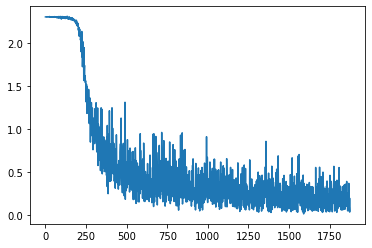

In [13]:
plt.plot(losses)

In [14]:
y_pred=net.forward(X_train)


m=np.max(y_pred,axis=1).reshape(-1,1)
e=np.exp(y_pred-m)
loss=np.log(e.sum(axis=1)).reshape(-1,1)+m-y_pred[np.arange(y_pred.shape[0]),y_train.astype(int)].reshape(-1,1)
ans=np.argsort(loss.reshape(-1))[::-1]


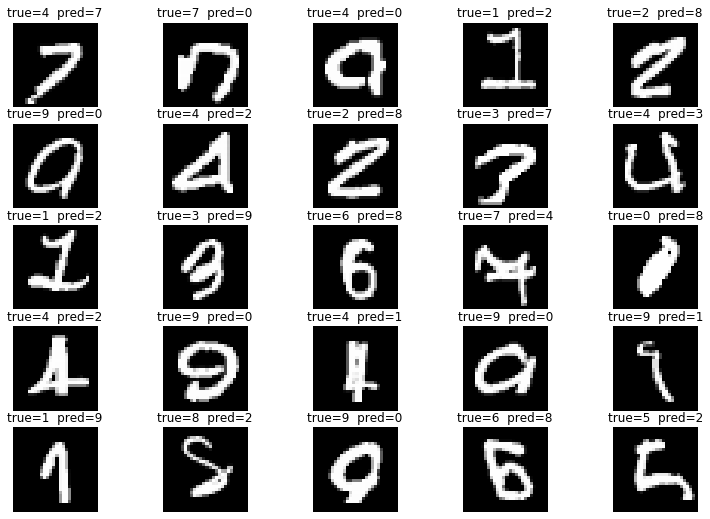

In [15]:
classes=np.argmax(y_pred,axis=1)
plt.figure(figsize=(13, 9))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[ans[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('true={0}  pred={1}'.format(int(y_train[ans[i]]),classes[ans[i]]))
    plt.axis('off')

### HW1 (1 балл): Реализовать Tanh

In [16]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self,X):
        self.X=np.exp(2*X)
        return (self.X-1)/(self.X+1)
    
    def backward(self,dLdy):
        return (4*self.X/(self.X+1)**2)*dLdy
    
    def step(self,_):
        pass

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [49]:
nl=NLLLoss()
losses0=[]
net=NeuralNetwork([Linear(784, 100),Tanh(),Linear(100, 100),Tanh(),Linear(100, 10)])

batch_size=32
num_ep=40

X=np.empty((batch_size,784))
y=np.empty((batch_size,)).astype(int)

idc=np.arange(X_train.shape[0])
for ep in range(num_ep):
    np.random.shuffle(idc)
    X_train=X_train[idc]
    y_train=y_train[idc]
    for i in range(0,X_train.shape[0],batch_size):
        X=X_train[i:min(i+batch_size,X_train.shape[0])]
        y=y_train[i:min(i+batch_size,X_train.shape[0])].astype(int)

        y_pred=net.forward(X)
        loss=nl.forward(y_pred,y)
        losses0.append(loss)
        net.backward(nl.backward())
        net.step(0.05)

print(f'default loss = {nl.forward(net.forward(X_test),y_test)}')

default loss = 0.09386295542086744


In [18]:
import random
import scipy.ndimage

X_train1=np.empty((X_train.shape[0]*2,784))
y_train1=np.empty((X_train.shape[0]*2))

X_train1[:X_train.shape[0]]=X_train[:]
y_train1[:X_train.shape[0]]=y_train[:]
y_train1[X_train.shape[0]:]=y_train[:]

for i in range(X_train.shape[0],X_train.shape[0]*2):
    alpha=random.uniform(-15,15)
    X_train1[i]=scipy.ndimage.rotate(X_train[i-X_train.shape[0]].reshape(28,-1),alpha,reshape=False,cval=-0.4242129623889923).reshape(-1)



In [42]:
nl=NLLLoss()
losses1=[]
net=NeuralNetwork([Linear(784, 100),Tanh(),Linear(100, 100),Tanh(),Linear(100, 10)])

batch_size=32
X=np.empty((batch_size,784))
y=np.empty((batch_size,)).astype(int)
idc=np.arange(X_train1.shape[0])
for ep in range(num_ep//2):
    np.random.shuffle(idc)
    X_train1=X_train1[idc]
    y_train1=y_train1[idc]
    for i in range(0,X_train1.shape[0],batch_size):
        X=X_train1[i:min(i+batch_size,X_train1.shape[0])]
        y=y_train1[i:min(i+batch_size,X_train1.shape[0])].astype(int)

        y_pred=net.forward(X)
        loss=nl.forward(y_pred,y)
        losses1.append(loss)
        net.backward(nl.backward())
        net.step(0.05)
print(f'loss с поворотом = {nl.forward(net.forward(X_test),y_test)}')

loss с поворотом = 0.08777791818034925


In [20]:
X_train2=np.empty((X_train.shape[0]*2,784))
y_train2=np.empty((X_train.shape[0]*2))

X_train2[:X_train.shape[0]]=X_train[:]
y_train2[:X_train.shape[0]]=y_train[:]
y_train2[X_train.shape[0]:]=y_train[:]

for i in range(X_train.shape[0],X_train.shape[0]*2):
    hor=random.randint(-3,3)
    ver=random.randint(-3,3)
    
    tmp=np.empty((28,28))
    
    if ver>0:
        tmp[ver:]=X_train[i-X_train.shape[0]].reshape(28,28)[:-ver]
        tmp[:ver]=-0.4242129623889923
    elif ver<0:
        tmp[:ver]=X_train[i-X_train.shape[0]].reshape(28,28)[-ver:]
        tmp[ver:]=-0.4242129623889923

    if hor>0:
        tmp[:,hor:]=tmp[:,:-hor]
        tmp[:,:hor]=-0.4242129623889923
    elif hor<0:
        tmp[:,:hor]=tmp[:,-hor:]
        tmp[:,hor:]=-0.4242129623889923
    
    X_train2[i]=tmp.reshape(-1)
        
    
    


In [46]:
nl=NLLLoss()
losses2=[]
net=NeuralNetwork([Linear(784, 100),Tanh(),Linear(100, 100),Tanh(),Linear(100, 10)])

batch_size=32
X=np.empty((batch_size,784))
y=np.empty((batch_size,)).astype(int)
idc=np.arange(X_train2.shape[0])
for ep in range(num_ep//2):
    np.random.shuffle(idc)
    X_train2=X_train2[idc]
    y_train2=y_train2[idc]
    for i in range(0,X_train2.shape[0],batch_size):
        X=X_train2[i:min(i+batch_size,X_train2.shape[0])]
        y=y_train2[i:min(i+batch_size,X_train2.shape[0])].astype(int)

        y_pred=net.forward(X)
        loss=nl.forward(y_pred,y)
        losses2.append(loss)
        net.backward(nl.backward())
        net.step(0.05)
print(f'loss со сдвигом = {nl.forward(net.forward(X_test),y_test)}')

loss со сдвигом = 0.10160574391631332


In [44]:
X_train3=np.empty((X_train.shape[0]*2,784))
y_train3=np.empty((X_train.shape[0]*2))

X_train3[:X_train.shape[0]]=X_train[:]
y_train3[:X_train.shape[0]]=y_train[:]
y_train3[X_train.shape[0]:]=y_train[:]

noise = np.random.normal(0,1,(X_train.shape[0],784))
X_train3[X_train.shape[0]:]=X_train+noise*0.1
    

In [48]:
nl=NLLLoss()
losses3=[]
net=NeuralNetwork([Linear(784, 100),Tanh(),Linear(100, 100),Tanh(),Linear(100, 10)])

batch_size=32
X=np.empty((batch_size,784))
y=np.empty((batch_size,)).astype(int)
idc=np.arange(X_train3.shape[0])
for ep in range(num_ep//2):
    np.random.shuffle(idc)
    X_train3=X_train3[idc]
    y_train3=y_train3[idc]
    for i in range(0,X_train3.shape[0],batch_size):
        X=X_train3[i:min(i+batch_size,X_train3.shape[0])]
        y=y_train3[i:min(i+batch_size,X_train3.shape[0])].astype(int)

        y_pred=net.forward(X)
        loss=nl.forward(y_pred,y)
        losses3.append(loss)
        net.backward(nl.backward())
        net.step(0.05)
print(f'loss с шумом = {nl.forward(net.forward(X_test),y_test)}')

loss с шумом = 0.09006912163888492


Text(0.5, 1.0, 'Default')

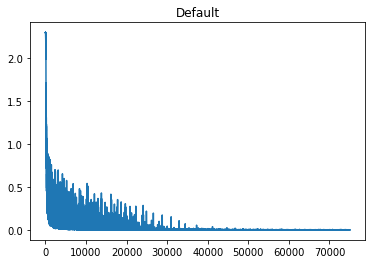

In [24]:
plt.plot(losses0)
plt.title('Default')

Text(0.5, 1.0, 'Повороты')

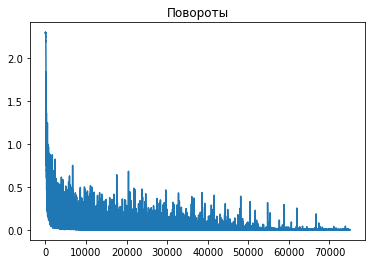

In [25]:
plt.plot(losses1)
plt.title('Повороты')

Text(0.5, 1.0, 'Сдвиги')

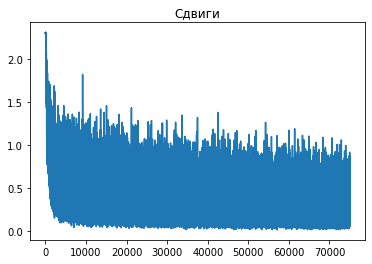

In [26]:
plt.plot(losses2)
plt.title('Сдвиги')

Text(0.5, 1.0, 'Шум')

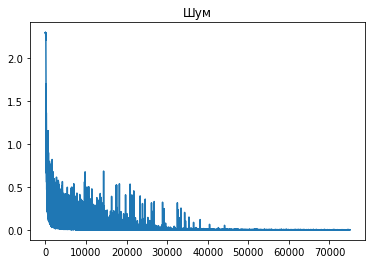

In [27]:
plt.plot(losses3)
plt.title('Шум')

***Сдвиг не даёт прирост, поэтому я на нём обучаться не буду***

In [51]:
X_train4=np.empty((X_train.shape[0]*4,784))
y_train4=np.empty((X_train.shape[0]*4))

X_train4[:X_train.shape[0]]=X_train[:]
X_train4[X_train.shape[0]:X_train.shape[0]*2]=X_train1[X_train.shape[0]:]
X_train4[X_train.shape[0]*2:X_train.shape[0]*3]=X_train3[X_train.shape[0]:]

noise = np.random.normal(0,1,(X_train.shape[0],784))
X_train4[X_train.shape[0]*3:]=X_train1[X_train.shape[0]:]+noise*0.1

y_train4[:X_train.shape[0]]=y_train[:]
y_train4[X_train.shape[0]:X_train.shape[0]*2]=y_train1[X_train.shape[0]:]
y_train4[X_train.shape[0]*2:X_train.shape[0]*3]=y_train3[X_train.shape[0]:]
y_train4[X_train.shape[0]*3:]=y_train1[X_train.shape[0]:]


In [52]:
nl=NLLLoss()
losses4=[]
net=NeuralNetwork([Linear(784, 100),Tanh(),Linear(100, 100),Tanh(),Linear(100, 10)])

batch_size=32
X=np.empty((batch_size,784))
y=np.empty((batch_size,)).astype(int)
idc=np.arange(X_train4.shape[0])
for ep in range(num_ep//4):
    np.random.shuffle(idc)
    X_train4=X_train4[idc]
    y_train4=y_train4[idc]
    for i in range(0,X_train4.shape[0],batch_size):
        X=X_train4[i:min(i+batch_size,X_train4.shape[0])]
        y=y_train4[i:min(i+batch_size,X_train4.shape[0])].astype(int)

        y_pred=net.forward(X)
        loss=nl.forward(y_pred,y)
        losses4.append(loss)
        net.backward(nl.backward())
        net.step(0.05)
print(f'loss с шумом и поворотом = {nl.forward(net.forward(X_test),y_test)}')

loss с шумом и поворотом = 0.08479903683638675


Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [29]:
nl=NLLLoss()
losses_train={'Sigmoid':[],'Relu':[],'Elu':[],'Tanh':[]}
losses_test={'Sigmoid':[],'Relu':[],'Elu':[],'Tanh':[]}
activations={'Sigmoid':Sigmoid,'Relu':Relu,'Elu':Elu,'Tanh':Tanh}

for act in ['Sigmoid','Relu','Elu','Tanh']:
    activation=activations[act]
    net=NeuralNetwork([Linear(784, 100),activation(),Linear(100, 100),activation(),Linear(100, 10)])
    
    test_iter=iter(test_loader)
    for X,y in train_loader:
        X=X.view(X.shape[0],-1)
        X=X.numpy()
        y=y.numpy()
        try:
            x_test,y_test=next(test_iter)
        except StopIteration:
            test_iter=iter(test_loader)
            x_test,y_test=next(test_iter)
        finally:
            x_test=x_test.view(x_test.shape[0],-1)
            x_test=x_test.numpy()
            y_test=y_test.numpy()
        
        y_pred=net.forward(X)
        loss=nl.forward(y_pred,y)
        losses_train[act].append(loss)
        losses_test[act].append(nl.forward(net.forward(x_test),y_test))
        net.backward(nl.backward())
        net.step(0.01)


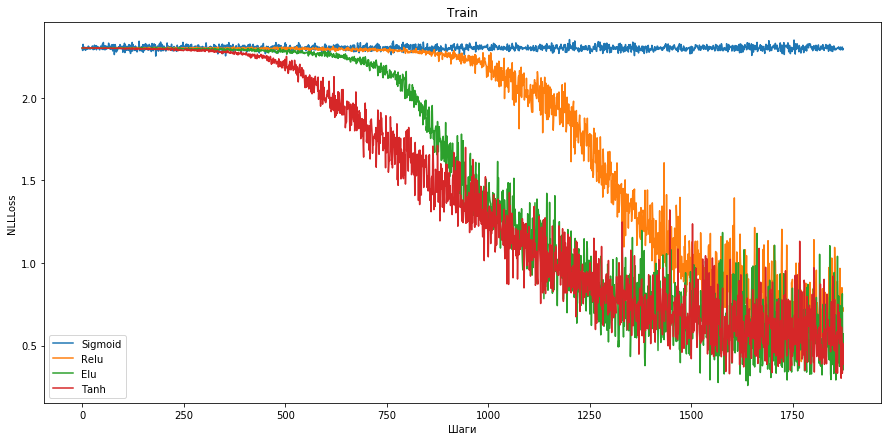

In [30]:
plt.figure(figsize=(15,7))
plt.title('Train')
plt.xlabel('Шаги')
plt.ylabel('NLLLoss')
for act in ['Sigmoid','Relu','Elu','Tanh']:
    plt.plot(losses_train[act],label=act)
plt.legend()
plt.show()

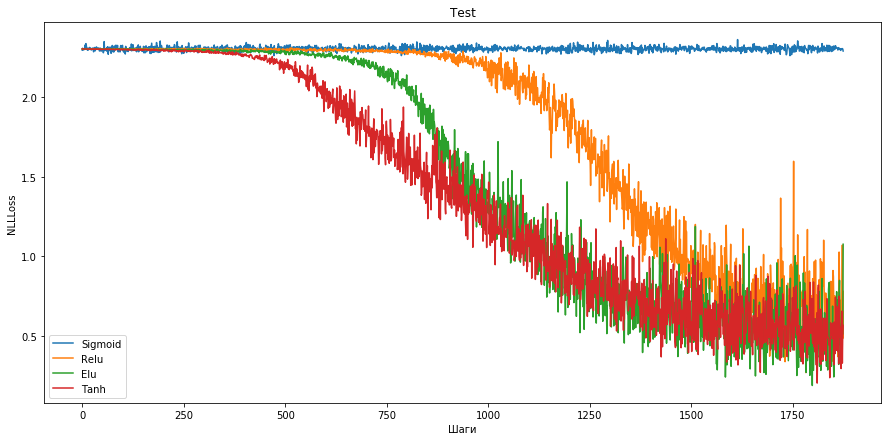

In [31]:
plt.figure(figsize=(15,7))
plt.title('Test')
plt.xlabel('Шаги')
plt.ylabel('NLLLoss')
for act in ['Sigmoid','Relu','Elu','Tanh']:
    plt.plot(losses_test[act],label=act)
plt.legend()
plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

***Различные активации значительно влияют на скорость сходимости и loss. Аугментации дали прирост примерно в 10 процентов***